# Car Brand Image Recognition with Transfer Learning

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import numpy as np
from glob import glob
from matplotlib import pyplot as plt

In [2]:
# resize all images to this
img_size = [224, 224]

train_path = './data/Train'
validation_path = './data/Test'

In [3]:
# initiate ResNet50 model with imagenet weights

resnet = ResNet50(input_shape = img_size + [3],
                  weights = 'imagenet',
                  include_top = False)

In [4]:
# freeze the existing weights
for layer in resnet.layers:
    layer.trainable = False

In [8]:
# define the output layer
flatten_layer = tf.keras.layers.Flatten()(resnet.output)
dense_layer = tf.keras.layers.Dense(256, activation = 'relu')(flatten_layer)
output_layer = tf.keras.layers.Dense(3, activation = 'softmax')(dense_layer)

In [9]:
# create the model object
model = tf.keras.Model(inputs = resnet.input, outputs = output_layer)

In [10]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [11]:
# define the metrics and optimization method
model.compile( loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [12]:
# data augmentation
train_datagen = ImageDataGenerator( rescale = 1./ 255.,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)

validation_datagen = ImageDataGenerator( rescale = 1./255. )

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size = img_size,
                                                    batch_size = 32,
                                                    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(validation_path,
                                                              target_size = img_size,
                                                              batch_size =32,
                                                              class_mode = 'categorical')

Found 64 images belonging to 3 classes.
Found 58 images belonging to 3 classes.


In [13]:
# fit the model
history = model.fit_generator(train_generator,
                              validation_data = validation_generator,
                              steps_per_epoch = len(train_generator),
                              validation_steps = len(validation_generator),
                              epochs = 50)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
2/2 [==============================] - 4s 2s/step - loss: 24.8862 - accuracy: 0.3281 - val_loss: 19.7205 - val_accuracy: 0.1552
Epoch 2/50
2/2 [==============================] - 4s 2s/step - loss: 17.0701 - accuracy: 0.3750 - val_loss: 18.2726 - val_accuracy: 0.3276
Epoch 3/50
2/2 [==============================] - 4s 2s/step - loss: 17.2016 - accuracy: 0.3906 - val_loss: 7.2759 - val_accuracy: 0.5172
Epoch 4/50
2/2 [==============================] - 4s 2s/step - loss: 13.3008 - accuracy: 0.3594 - val_loss: 9.1692 - val_accuracy: 0.5172
Epoch 5/50
2/2 [==============================] - 4s 2s/step - loss: 11.9801 - accuracy: 0.3438 - val_loss: 3.7846 - val_accuracy: 0.5690
Epoch 6/50
2/2 [==============================] - 4s 2s/step - loss: 6.2113 - accuracy: 0.4375 - val_loss: 6.3090 - val_accuracy: 0.3276
Epoch 7/50
2/2 [==============================] - 4s 2s/step - loss: 5.3101 - accuracy: 0.3906 

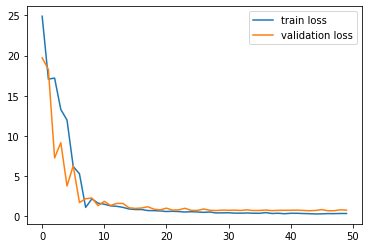

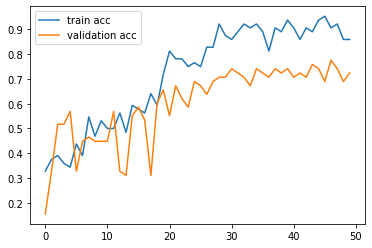

<Figure size 432x288 with 0 Axes>

In [14]:
# plot the loss
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.show()
plt.savefig('./figures/Loss')

#plot the accuracy
plt.plot(history.history['accuracy'], label = 'train acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()
plt.show()
plt.savefig('./figures/Accuracy')

In [15]:
# save the model as an h5 file
model.save('./model/carbrand_resnet50.h5')

In [16]:
# predicting the test set
y_pred = model.predict(validation_generator)

In [17]:
y_pred = np.argmax(y_pred, axis = 1)
y_pred

array([1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1,
       1, 2, 1, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1, 1,
       1, 2, 2, 0, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1])

In [18]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
from glob import glob

model = load_model('./model/carbrand_resnet50.h5')

In [19]:
folders = glob('./data/Train/*')
labels = []

for path in folders:
    l = path.split('/')
    label = l[-1].upper()
    labels.append(label)
labels.sort()
print(labels)

['AUDI', 'LAMBORGHINI', 'MERCEDES']


In [20]:
def Predict_Brand(image_path, image_size = [224, 224], labels = labels, model = model):
    img = load_img(image_path, target_size = image_size)
    x = image.img_to_array(img).astype(float)
    x = x / 255.
    x = np.expand_dims(x, axis = 0)
    result = model.predict(x)
    result = np.argmax(result, axis = 1)
    return labels[result[0]]

result = Predict_Brand('./data/Test/audi/25.jpg')
print(result)

AUDI
